## Notebook setup

In [57]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd

from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [3]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [58]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
symbol = "ENB"

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]
exchange = "NYSE"
report_name = f"{symbol}".upper()

 

In [7]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [8]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for ENB with starting period 2021-07-28.

('Investment Research Report on ENB',
 '19 January, 2023',
 '16:43',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [9]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/23,ending 12/31/24
No. of Analysts,2,2,2,5,4
Average Estimate,"13,479 CAD","16,033 CAD","14,614 CAD","52,368 CAD","51,136 CAD"
Year Ago,-,-,-,-,"52,368 CAD"
Publish Date,2/10/2023,5/11/2023,8/4/2023,-,-


In [10]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)

In [11]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

19 news articles for  Enbridge Inc. were found since 2023-01-12

In [12]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Royal Bank of Canada,160.176 M,2022-09-29,7.91 %,6.628 B
2,"Vanguard Group, Inc. (The)",73.350 M,2022-09-29,3.62 %,3.035 B
3,Bank of Montreal/Can/,65.629 M,2022-09-29,3.24 %,2.716 B
4,GQG Partners LLC,56.235 M,2022-09-29,2.78 %,2.327 B
5,Deutsche Bank Aktiengesellschaft,41.819 M,2022-09-29,2.07 %,1.730 B
6,"TD Asset Management, Inc",29.260 M,2022-09-29,1.45 %,1.211 B
7,Bank Of Nova Scotia /,23.468 M,2022-09-29,1.16 %,971.107 M
8,1832 Asset Management L.P.,22.223 M,2022-09-29,1.10 %,919.597 M
9,"Cibc World Markets, Inc.",21.914 M,2022-09-29,1.08 %,906.795 M
10,Manufacturers Life Insurance Co.,20.228 M,2022-09-29,1.00 %,837.017 M


In [13]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,Royal Bank of Canada,160.176 M,2022-09-29,7.91 %,6.628 B
1,"Vanguard Group, Inc. (The)",73.350 M,2022-09-29,3.62 %,3.035 B
2,Bank of Montreal/Can/,65.629 M,2022-09-29,3.24 %,2.716 B
3,GQG Partners LLC,56.235 M,2022-09-29,2.78 %,2.327 B
4,Deutsche Bank Aktiengesellschaft,41.819 M,2022-09-29,2.07 %,1.730 B
5,"TD Asset Management, Inc",29.260 M,2022-09-29,1.45 %,1.211 B
6,Bank Of Nova Scotia /,23.468 M,2022-09-29,1.16 %,971.107 M
7,1832 Asset Management L.P.,22.223 M,2022-09-29,1.10 %,919.597 M
8,"Cibc World Markets, Inc.",21.914 M,2022-09-29,1.08 %,906.795 M
9,Manufacturers Life Insurance Co.,20.228 M,2022-09-29,1.00 %,837.017 M


In [14]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Royal Bank of Canada,160.176 M,2022-09-29,7.91 %,6.628 B
2,"Vanguard Group, Inc. (The)",73.350 M,2022-09-29,3.62 %,3.035 B
3,Bank of Montreal/Can/,65.629 M,2022-09-29,3.24 %,2.716 B
4,GQG Partners LLC,56.235 M,2022-09-29,2.78 %,2.327 B
5,Deutsche Bank Aktiengesellschaft,41.819 M,2022-09-29,2.07 %,1.730 B
6,"TD Asset Management, Inc",29.260 M,2022-09-29,1.45 %,1.211 B
7,Bank Of Nova Scotia /,23.468 M,2022-09-29,1.16 %,971.107 M
8,1832 Asset Management L.P.,22.223 M,2022-09-29,1.10 %,919.597 M
9,"Cibc World Markets, Inc.",21.914 M,2022-09-29,1.08 %,906.795 M
10,Manufacturers Life Insurance Co.,20.228 M,2022-09-29,1.00 %,837.017 M


In [15]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)[["Type", "Category", "Link"]].head(
    5
)
df_sec_filings["Link"] = df_sec_filings["Link"].apply(
    lambda x: f'<a href="{x}">{x}</a>'
)
df_sec_filings

,Type,Category,Link
Filing Date,,,
12/15/2022,8-K/A,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16262306"">https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16262306</a>"
11/30/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16235431"">https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16235431</a>"
11/04/2022,10-Q,Quarterly Reports,"<a href=""https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16176681"">https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16176681</a>"
11/04/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16176677"">https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16176677</a>"
10/04/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16116452"">https://www.marketwatch.com/investing/stock/enb/financials/secfilings?docid=16116452</a>"


In [16]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

Error: "None of ['date'] are in the columns"

In [17]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-01-18,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-01-17,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-01-13,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-01-12,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-01-11,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy


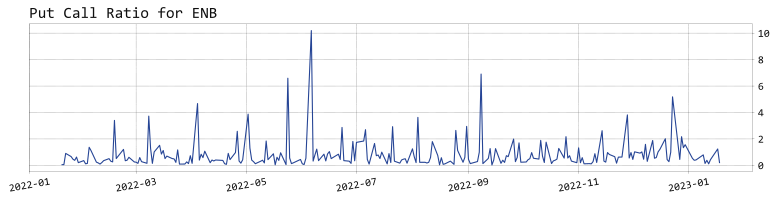

In [18]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [19]:
expiry_dates = openbb.stocks.options.expirations(symbol)
if (len(expiry_dates) > 0):
    exp = expiry_dates[0]
    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
else:
    option_chain = pd.DataFrame()


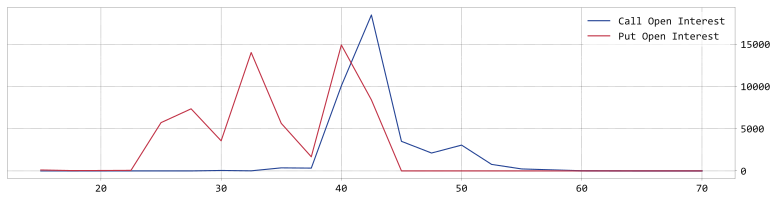

In [20]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    ax.plot(
        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
    )
    ax.plot(
        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
    )
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    vol_chart = f.getvalue().decode("utf-8")

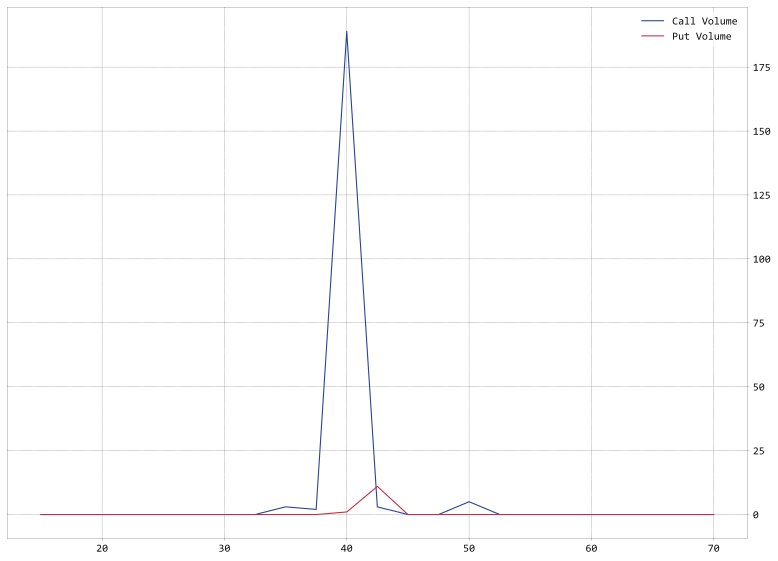

In [21]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    voi_chart = f.getvalue().decode("utf-8")

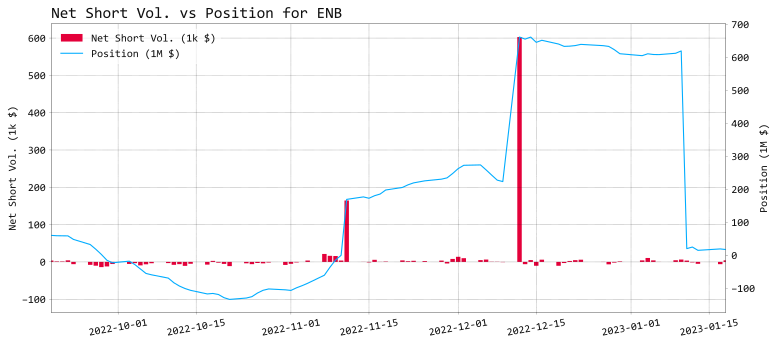

In [22]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

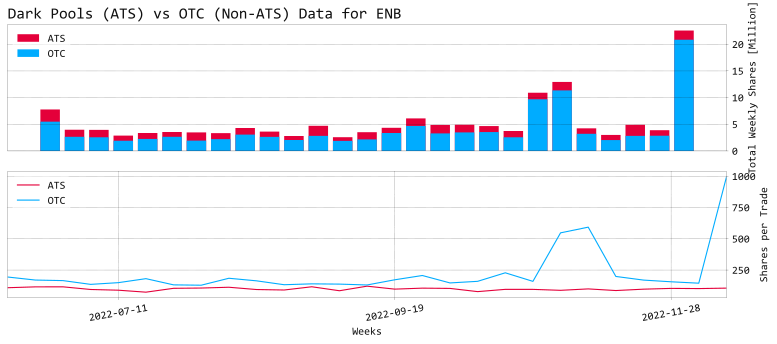

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

No recent congress trading data found

No congress trading data found

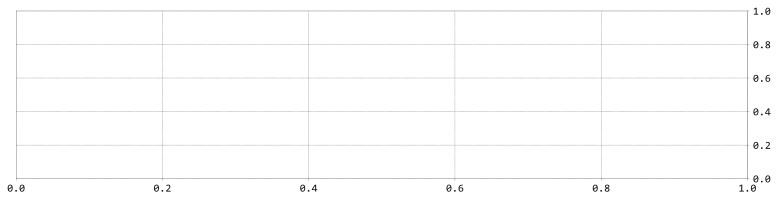

In [24]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

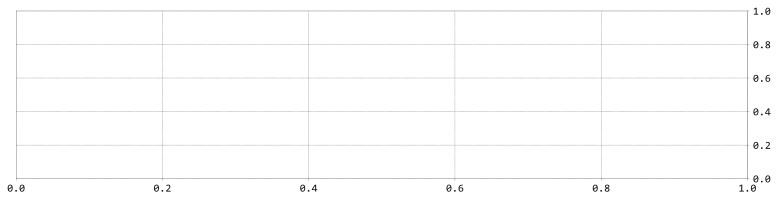

In [25]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

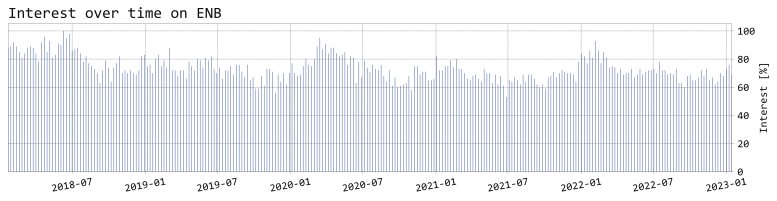

In [26]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

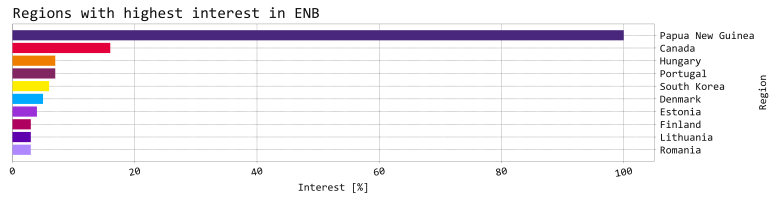

In [27]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")


3 Failed downloads:
- APC: No data found, symbol may be delisted
- EEP: No data found for this date range, symbol may be delisted
- EEQ: No data found for this date range, symbol may be delisted


NaN values found in: APC, EEP, EEQ.  Backfilling data

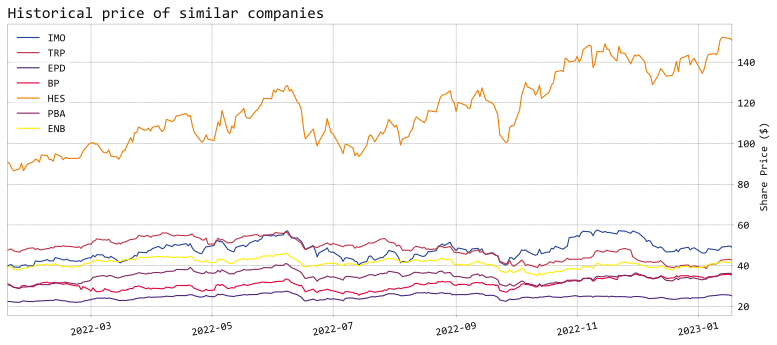

In [28]:
similar_companies_dict={'FTCO': ['GOLD','KGC','AU','AEM','NEM'],
                        'AR': ['RRC', 'EQT','SWN','CNX','CHK'],
                        'FLNG' : ['GLNG','SFL'],
                        'GSL' : ['DAC','CMRE','SFL'],
                        'MP' : ['SGML','LAC','MTRN'],
                        'INSW' : ['FRO','TRMD','EURN'],
                        'MPLX' : ['AM','EPD','ENB','PBA','ET'],
                        'ZIM' : ['MATX'],
                        'KNTK' : ['AM','EPD','ENB','PBA','ET','MPLX'],
                        'AM' : ['EPD','ET','ENB','PBA','MPLX']}
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")


3 Failed downloads:
- APC: No data found, symbol may be delisted
- EEP: No data found for this date range, symbol may be delisted
- EEQ: No data found for this date range, symbol may be delisted


NaN values found in: APC, EEP, EEQ.  Backfilling data

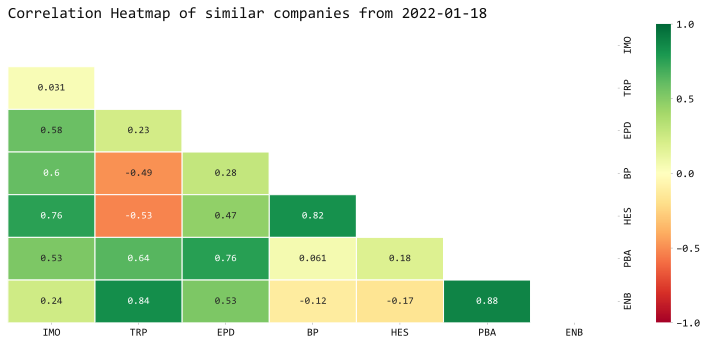

In [29]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")


3 Failed downloads:
- APC: No data found, symbol may be delisted
- EEP: No data found for this date range, symbol may be delisted
- EEQ: No data found for this date range, symbol may be delisted


NaN values found in: APC, EEP, EEQ.  Backfilling data

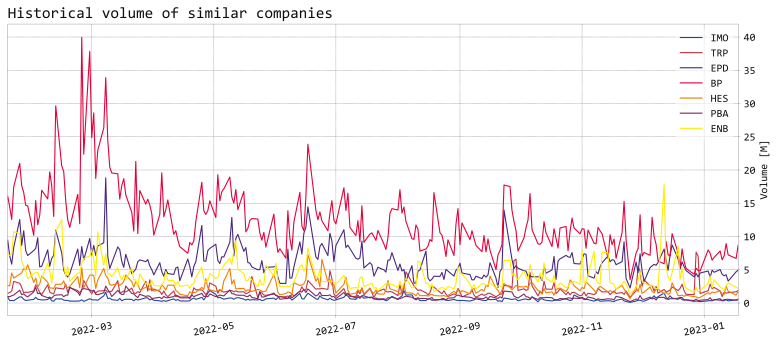

In [30]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

Request error in retrieving IMO sentiment from FinBrain API

Unexpected data format or no data from FinBrain API for TRP

Unexpected data format or no data from FinBrain API for BP

Unexpected data format or no data from FinBrain API for HES

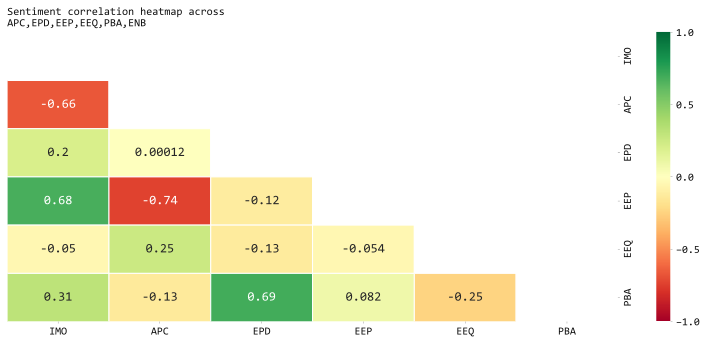

In [31]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [32]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,ENB,8.340000e+10,20.30,13.54,2.13,1.92,109.15,NaN,0.946,0.0382,0.0820
1,EPD,5.450000e+10,10.94,9.82,0.97,2.08,326.36,30.69,0.219,0.0306,0.1600
2,PBA,1.976000e+10,10.01,16.14,1.72,1.44,NaN,NaN,1.315,-0.3570,0.1092


In [33]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,ENB,0.0643,0.032,0.099,0.049,0.6,0.5,1.27,1.42,0.384,0.170,0.105
1,EPD,0.0780,0.073,0.196,0.110,0.9,0.6,1.01,1.11,0.175,0.117,0.090
2,PBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])

ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,ENB,2.020000e+09,2.020000e+09,0.0920,0.0000,0.7050,0.0016,0.0251,14.30
1,EPD,2.180000e+09,1.470000e+09,0.3263,0.0001,0.2720,-0.0104,0.0134,3.53
2,PBA,5.515600e+08,5.511500e+08,0.0007,0.0000,0.6219,NaN,0.0184,16.49


In [35]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])

performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,ENB,0.0051,0.0581,0.1120,-0.0454,-0.0113,0.0535,0.0139,0.0159,2.3
1,EPD,-0.0091,0.0406,-0.0087,-0.0055,0.0479,0.0423,0.0151,0.0165,1.8
2,PBA,0.0347,0.0754,0.1379,-0.0194,0.1117,0.0551,0.0184,0.0195,2.2


In [36]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [37]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

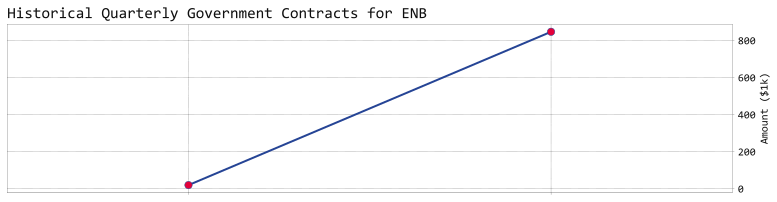

In [38]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [39]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

Date Ticker                                          Client  \
0  2023-01-12    ENB  ENBRIDGE (U.S.) INC. (FORMERLY SPECTRA ENERGY)   
1  2023-01-09    ENB                   ENBRIDGE ENERGY COMPANY, INC.   
2  2022-10-20    ENB                             ENBRIDGE (U.S.) INC   
3  2022-10-17    ENB  ENBRIDGE (U.S.) INC. (FORMERLY SPECTRA ENERGY)   
4  2022-10-10    ENB                   ENBRIDGE ENERGY COMPANY, INC.   

     Amount  \
0   60000.0   
1   50000.0   
2  200000.0   
3   60000.0   
4   50000.0   

                                                                                                                                                            Issue  \
0                                                                                                                                                    Fuel/Gas/Oil   
1                                                                                                                                                  Energy/Nuclear   
2  Budget/Appropriations \n Homeland Security \n Transportation \n Natural Resources \n Environment/Superfund \n Taxation/Internal Revenue Code \n Energy/Nuclear   
3                                                                                                                                                    Fuel/Gas/Oil   
4                                                                                                                                                  Energy/Nuclear   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

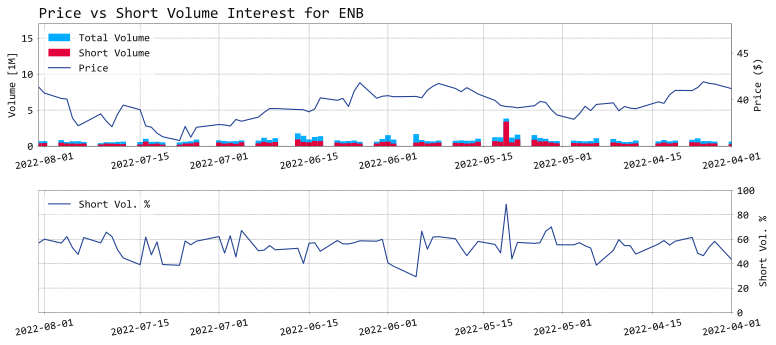

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

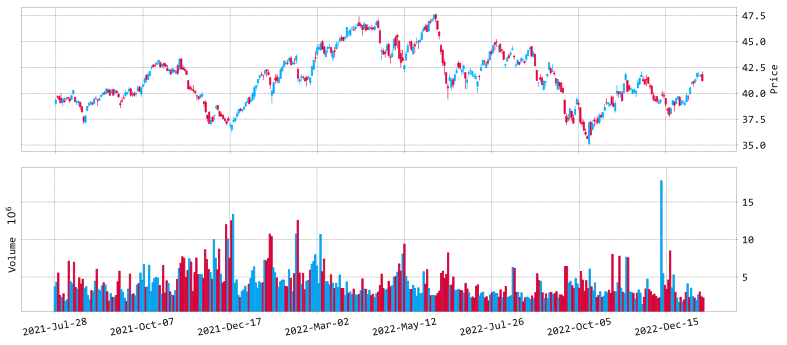

In [41]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

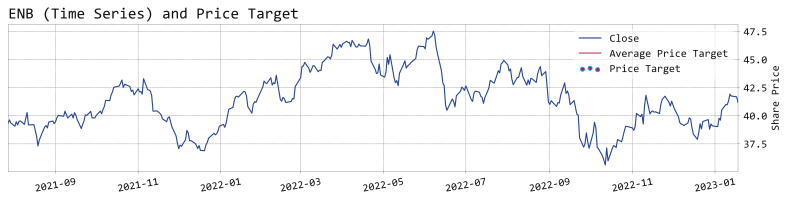

In [42]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [43]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

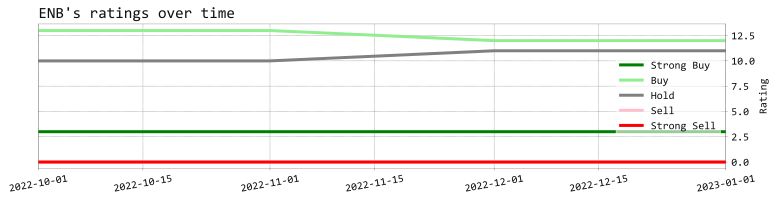

In [44]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

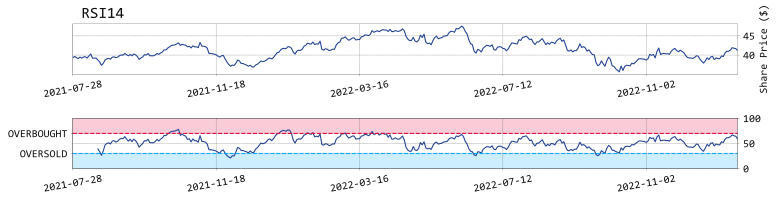

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [46]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

58.74

In [47]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [48]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

Error: "None of ['Date'] are in the columns"

empty


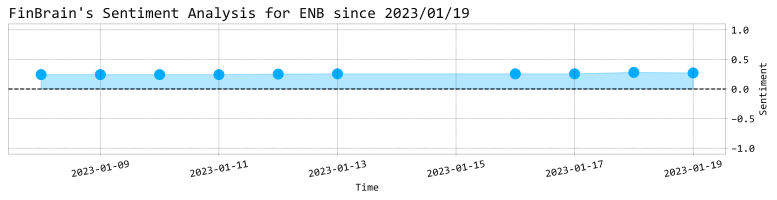

In [49]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [50]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [51]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 7157</br>\nLast 2 sentiment messages:</br>Bullish 50.0%</br>Bearish 50.0%'


1 Failed download:
- ENB: 15m data not available for startTime=1596081600 and endTime=1674164714. The requested range must be within the last 60 days.


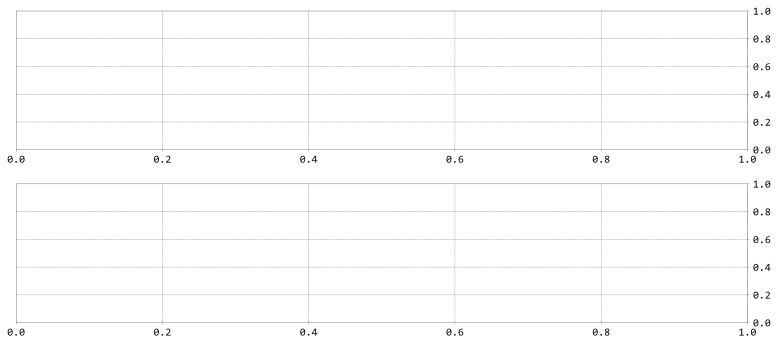

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [53]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for ENB with starting period 2019-08-08.

KeyboardInterrupt: 

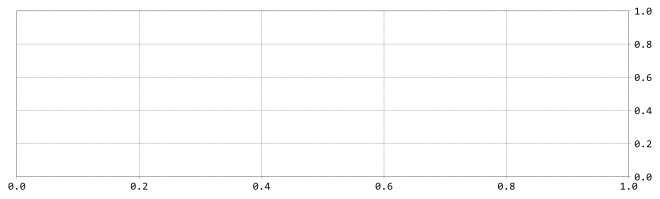

In [54]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

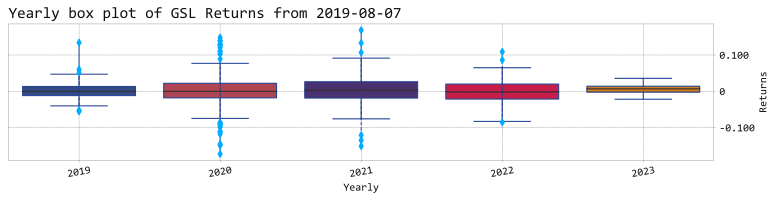

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [ ]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for GSL

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

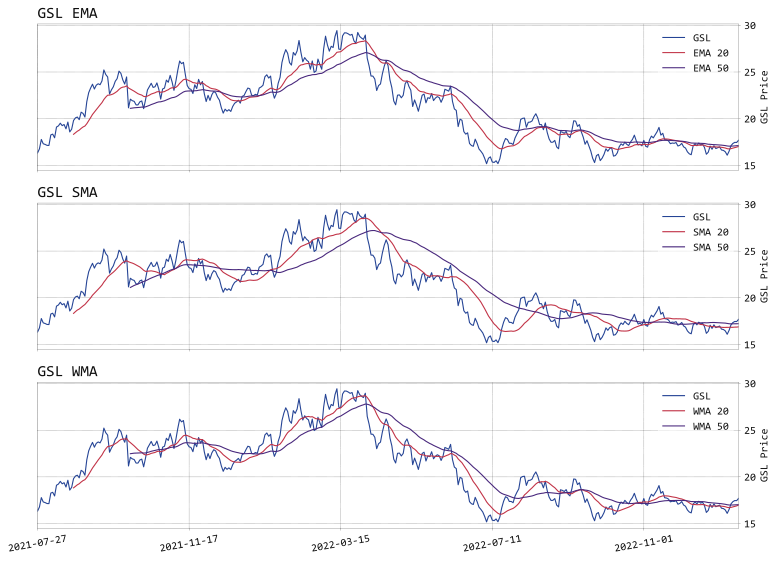

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

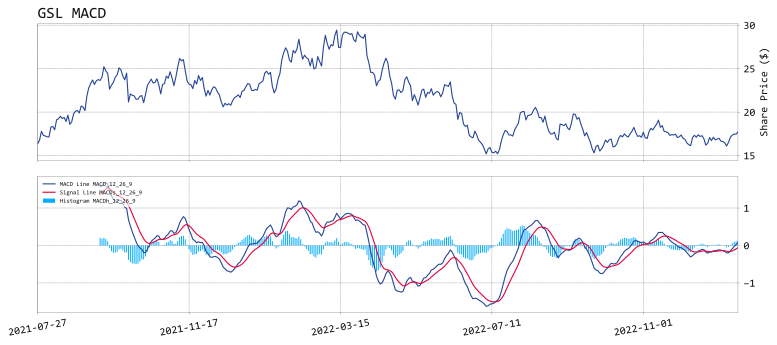

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

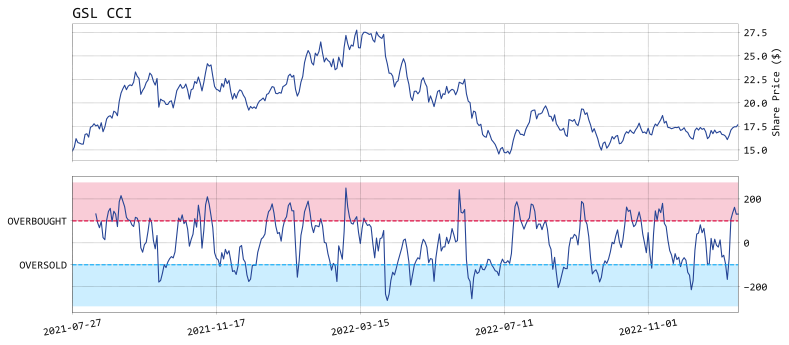

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

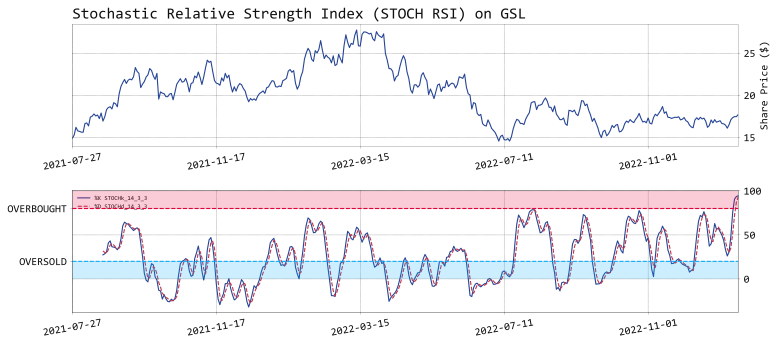

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

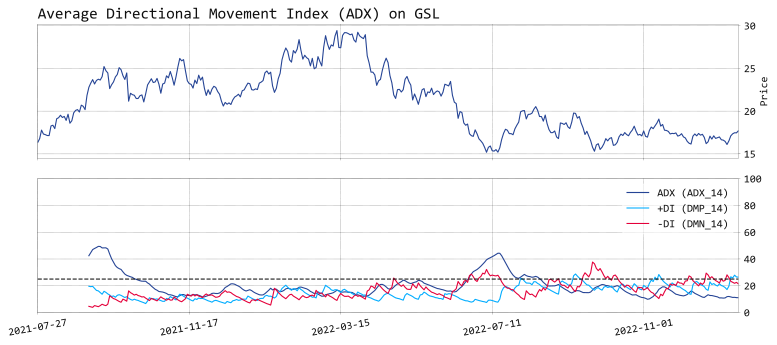

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

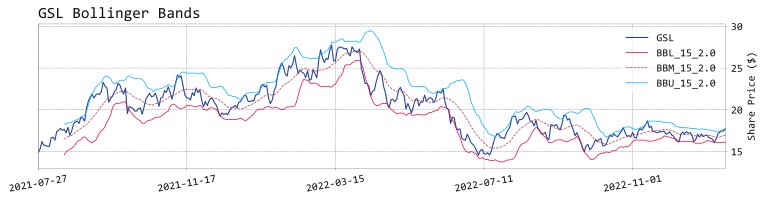

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

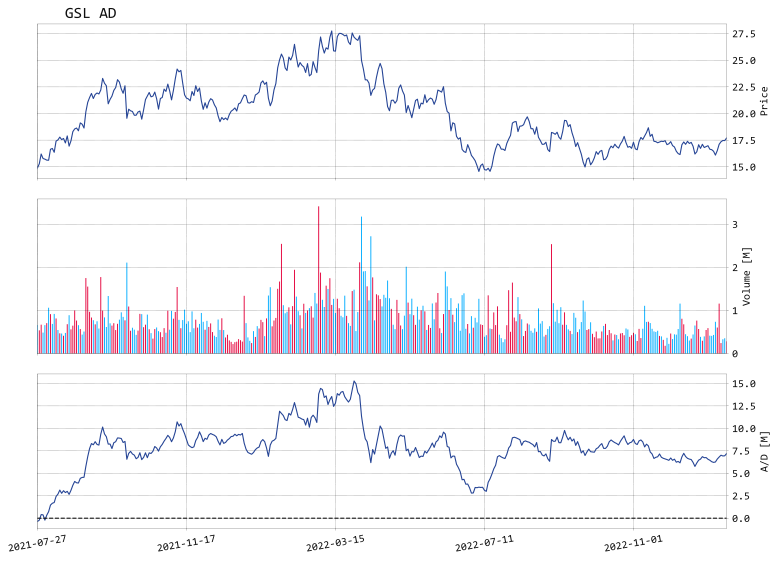

In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [ ]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
        {{
        "width": "1085",
        "height": "700",
        "colorTheme": "light",
        "isTransparent": false,
        "symbol": "{exchange}:{symbol}",
        "locale": "en"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
"""

body += widgets.add_tab("Summary", htmlcode, False)


htmlcode = f"""
<!-- TradingView Widget BEGIN -->
<div class="tradingview-widget-container">
  <div id="tradingview_fceac"></div>
  <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
  <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
  <script type="text/javascript">
  new TradingView.MediumWidget(
    {{
    "symbols": [
        [
        "{long_name}",
        "{exchange}:{symbol}|1D"
        ]
    ],
    "chartOnly": false,
    "width": "1085",
    "height": "700",
    "locale": "en",
    "colorTheme": "light",
    "autosize": false,
    "showVolume": false,
    "hideDateRanges": false,
    "hideMarketStatus": false,
    "scalePosition": "right",
    "scaleMode": "Normal",
    "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
    "fontSize": "10",
    "noTimeScale": false,
    "valuesTracking": "1",
    "chartType": "line",
    "container_id": "tradingview_fceac"
    }}
  );
  </script>
</div>
<!-- TradingView Widget END -->
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
     <div class="tweet-list">
        {% for tweet in tweets %}
        <div class="tweet">
            <div class="tweet-header">
                <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                <h3>{{ tweet.user.name }}</h3>                   
            </div>       
            <div class="tweet-body">
                <p>{{ tweet.full_text }}</p>
            </div>   
            {% if tweet.entities.media %}
                <div class="tweet-media">
                {% for media in tweet.entities.media %}
                    <img src="{{ media.media_url_https }}" alt="Tweet media">
                {% endfor %}
                </div>
            {% endif %}
            <div class="tweet-footer">
                {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                <p>{{ date }}</p>
                <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
            </div>
        </div>
        {% endfor %}
    </div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)
htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
        {{
        "colorTheme": "light",
        "isTransparent": false,
        "largeChartUrl": "",
        "displayMode": "regular",
        "width": "1085",
        "height": "800",
        "symbol": "{exchange}:{symbol}",
        "locale": "en"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
"""

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass


body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
if not option_chain.empty:
    htmlcode += widgets.row(
        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
    )
    htmlcode += widgets.row(
        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
    )
try:
    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
except:
    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

try:
    htmlcode = widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)


htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
        {{
        "interval": "1W",
        "width": "1085",
        "isTransparent": false,
        "height": "700",
        "symbol": "{exchange}:{symbol}",
        "showIntervalTabs": true,
        "locale": "en",
        "colorTheme": "light"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)